<a href="https://colab.research.google.com/github/id-gxon/stockpred/blob/main/%EC%88%9C%ED%99%98%EC%8B%A0%EA%B2%BD%EB%A7%9D_%EC%A3%BC%EC%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [189]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import math
import numpy as np
import matplotlib.pyplot as plt

import time
import pandas_datareader as pdr # 주식데이터 크롤링

from jupyterthemes import jtplot # 시각화 테마 변경
jtplot.style(theme = 'grade3') 

In [178]:
# 실행 오류 발생시

# 1. pandas, pandas-datareader 업그레이드
# pip install --upgrade pandas
# pip install --upgrade pandas-datareader 

# 2. 런타임 초기화
# 메뉴의 '런타임'-'런타임 초기화' or '런타임 다시 시작'

In [179]:
pip install --upgrade pandas

In [180]:
pip install --upgrade pandas-datareader

In [186]:
code = '005930.KS' # 사용자로부터 종목코드를 받음
start = '2021-01-01' # 
end='2022-01-26'
epochs = 100

In [187]:
def rnn(code, start, end): # 순환신경망(RNN)분석 함수
    df = pdr.get_data_yahoo(code, start=start, end=end).reset_index()  # 주식 데이터 크롤링
    dataset = df['Close'].values # 종가 데이터 추출
    dataset = dataset.reshape(dataset.shape[0], 1) # 1차원배열을 2차원으로 변경
    dataset = dataset.astype('float32') # int -> float변환
    scaler = MinMaxScaler(feature_range=(0, 0.9)) # 최대값을 0.9로 설정
    Dataset = scaler.fit_transform(dataset)
    train_data, test_data = train_test_split(Dataset, test_size=0.2, shuffle=False) # 8:2로 tarin, test 분리

    def create_dataset(dataset, look_back): # 종속변수와 독립변수를 생성하는 함수
        x_data = [] # 빈 리스트 생성
        y_data = []

        for i in range(len(dataset) - look_back):
            data = dataset[i: (i + look_back), 0]
            x_data.append(data)
            y_data.append(dataset[i + look_back, 0])
        return np.array(x_data), np.array(y_data)

    look_back = 7 # 7개의 데이터로 예측
    x_train, y_train = create_dataset(train_data, look_back) # train_data 생성
    x_test, y_test = create_dataset(test_data, look_back) # test 데이터 생성

    X_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1])) # 3차원으로 변경
    X_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1])) # 3차원으로 변경

    model = Sequential() # model 옵션
    model.add(SimpleRNN(3, input_shape=(1, look_back)))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mse', optimizer='adam')

    model.fit(X_train, y_train, epochs=epochs, batch_size=1, verbose=1) # train_data학습

    trainPredict = model.predict(X_train) # train_data를 이용하여 예측
    testPredict = model.predict(X_test) # test_data를 이용하여 예측
    
    TrainPredict = scaler.inverse_transform(trainPredict) # Min-Max변환된 값을 원래대로 되돌림
    Y_train = scaler.inverse_transform([y_train]) # Min-Max변환된 값을 원래대로 되돌림
    TestPredict = scaler.inverse_transform(testPredict) # Min-Max변환된 값을 원래대로 되돌림
    Y_test = scaler.inverse_transform([y_test]) # Min-Max변환된 값을 원래대로 되돌림

    train_RMSE = math.sqrt(mean_squared_error(Y_train[0], TrainPredict[:, 0])) # train_RMSE
    test_RMSE = math.sqrt(mean_squared_error(Y_test[0], TestPredict[:, 0])) # test_RMSE

    x_pred = np.zeros(look_back * look_back, dtype = float) # 예측값을 저장할 array생성
    x_pred = x_pred.reshape(look_back, 1, look_back) # 3차원으로 변환
 
    for i in range(look_back):
      if i == 0:
        x_pred[0][0][:-1] = Dataset[-6:].reshape(6) # 최근 6일 데이터를 pred의 1번째 row, 1~6번째 인덱스에 저장
        x_pred[0][0][-1] = model.predict(Dataset[-7:].reshape(1, 1, look_back)) # 최근 7일 데이터를 이용한 예측값을 pred의 1번째 row, 7번째 인덱스에 저장
      elif i > 0:
        x_pred[i][0][:-1] = x_pred[i-1][0][1:] # pred의 이전 row의 2~7번째 데이터를 다음 row의 1~6번째 인덱스에 저장
        x_pred[i][0][-1] = model.predict(x_pred[[i-1]]) # pred의 이전 row의 1~7번째 데이터를 이용하여 데이터 예측 후, 다음 row의 7번재 인덱스에 저장

    trainPredictPlot = np.zeros(len(dataset) + 7)
    trainPredictPlot = trainPredictPlot.reshape(trainPredictPlot.shape[0], 1)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(TrainPredict) + look_back] = TrainPredict
    
    testPredictPlot = np.zeros(len(dataset) + 7)
    testPredictPlot = testPredictPlot.reshape(testPredictPlot.shape[0], 1)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(TrainPredict) + (look_back) * 2 : len(dataset) , :] = TestPredict

    predPlot = np.zeros(len(dataset) + 7)
    predPlot = predPlot.reshape(predPlot.shape[0], 1)
    predPlot[:, :] = np.nan
    predPlot[-7:] = x_pred[6].reshape(x_pred.shape[0], 1)
    predPlot = scaler.inverse_transform(predPlot) # Min-Max변환된 값을 원래대로 되돌림

    result = np.round(predPlot[-7:].reshape(look_back), 2)
    result_max = result.max()
    result_min = result.min()
    
    plt.figure(figsize = (20, 10))
    plt.plot(dataset, label = "true", c = 'green')
    plt.plot(trainPredictPlot, label = 'train_predict')
    plt.plot(testPredictPlot, label = 'test_predict')
    plt.plot(predPlot, label = 'pred')
    plt.legend()

    plt.show()
    return result, result_max, result_min, train_RMSE, test_RMSE



Epoch 1/100
205/205 [==============================] - 3s 4ms/step - loss: 0.0143
Epoch 2/100
205/205 [==============================] - 1s 4ms/step - loss: 0.0063
Epoch 3/100
205/205 [==============================] - 1s 4ms/step - loss: 0.0056
Epoch 4/100
205/205 [==============================] - 1s 5ms/step - loss: 0.0052
Epoch 5/100
205/205 [==============================] - 1s 5ms/step - loss: 0.0051
Epoch 6/100
205/205 [==============================] - 1s 6ms/step - loss: 0.0048
Epoch 7/100
205/205 [==============================] - 1s 5ms/step - loss: 0.0046
Epoch 8/100
205/205 [==============================] - 1s 5ms/step - loss: 0.0044
Epoch 9/100
205/205 [==============================] - 1s 6ms/step - loss: 0.0043
Epoch 10/100
205/205 [==============================] - 1s 5ms/step - loss: 0.0042
Epoch 11/100
205/205 [==============================] - 1s 4ms/step - loss: 0.0042
Epoch 12/100
205/205 [==============================] - 1s 3ms/step - loss: 0.0041
Epoch 13/100


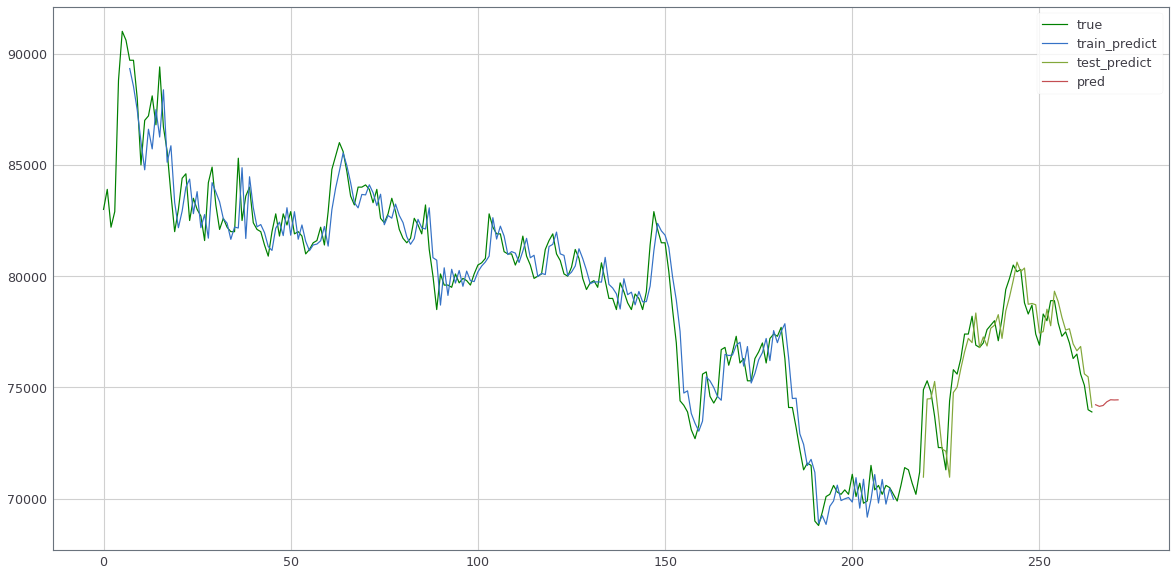



코드 진행시간(초) :  85.67079615592957

prediction :  [74224.63 74152.24 74190.75 74357.08 74448.61 74438.99 74444.67]
result_max :  74448.61
result_min :  74152.24
train_RMSE :  990.561335713837
test_RMSE :  1121.9886763639058


In [190]:
s = time.time()
result, result_max, result_min, train_RMSE, test_RMSE = rnn(code, start, end) # 함수 실행
e = time.time()

print()
print()

print('코드 진행시간(초) : ', e - s)
print()
print('prediction : ', result)
print('result_max : ', result_max)
print('result_min : ', result_min)
print('train_RMSE : ', train_RMSE)
print('test_RMSE : ', test_RMSE)

# 코드 진행상황확인 및 오류 잡기위한 부분

In [176]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [114]:
code = '005930.KS' # 사용자로부터 종목코드를 받음
start = '2021-07-01' # 
end='2022-01-26'
epochs = 100

df = pdr.get_data_yahoo(code, start=start, end=end).reset_index()  # 주식 데이터 크롤링
dataset = df['Close'].values # 종가 데이터 추출
dataset = dataset.reshape(dataset.shape[0], 1) # 1차원배열을 2차원으로 변경
dataset = dataset.astype('float32') # int -> float변환
scaler = MinMaxScaler(feature_range=(0, 0.9)) # 최대값이 0.9가 되록 설정
Dataset = scaler.fit_transform(dataset) 
train_data, test_data = train_test_split(Dataset, test_size=0.2, shuffle=False) # 8:2로 tarin, test 분리

In [115]:
df.head(2)

,Date,High,Low,Open,Close,Volume,Adj Close
0,2021-07-01,80600.0,80000.0,80500.0,80100.0,13382882.0,79721.023438
1,2021-07-02,80400.0,79900.0,80000.0,80000.0,8753097.0,79621.500000


In [116]:
dataset[:5]

array([[80100.],
       [80000.],
       [80400.],
       [81200.],
       [80800.]], dtype=float32)

In [117]:
Dataset[:5]

array([[0.7212763 ],
       [0.71489334],
       [0.7404251 ],
       [0.7914891 ],
       [0.76595736]], dtype=float32)

In [118]:
Dataset.max() 

0.8999996

In [119]:
def create_dataset(dataset, look_back): # 종속변수와 독립변수를 생성하는 함수
  x_data = [] # 빈 리스트 생성
  y_data = []

  for i in range(len(dataset) - look_back):
    data = dataset[i: (i + look_back), 0]
    x_data.append(data)
    y_data.append(dataset[i + look_back, 0])
  return np.array(x_data), np.array(y_data)

In [120]:
look_back = 7
x_train, y_train = create_dataset(train_data, look_back) # train_data 생성
x_test, y_test = create_dataset(test_data, look_back) # test 데이터 생성

In [121]:
x_train[:2]

array([[0.7212763 , 0.71489334, 0.7404251 , 0.7914891 , 0.76595736,
        0.7085104 , 0.6765957 ],
       [0.71489334, 0.7404251 , 0.7914891 , 0.76595736, 0.7085104 ,
        0.6765957 , 0.6957445 ]], dtype=float32)

In [122]:
y_train[:5]

array([0.6957445 , 0.70212746, 0.68297863, 0.7531915 , 0.70212746],
      dtype=float32)

In [123]:
x_test[:2]

array([[0.5617018 , 0.57446766, 0.587234  , 0.52978706, 0.59361696,
        0.6765957 , 0.7085104 ],
       [0.57446766, 0.587234  , 0.52978706, 0.59361696, 0.6765957 ,
        0.7085104 , 0.74680805]], dtype=float32)

In [124]:
y_test[:5]

array([0.74680805, 0.7276592 , 0.73404217, 0.63829756, 0.60638285],
      dtype=float32)

In [125]:
X_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
X_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [126]:
X_train.shape

(106, 1, 7)

In [127]:
X_test.shape

(22, 1, 7)

In [128]:
model = Sequential() # model 옵션
model.add(SimpleRNN(3, input_shape=(1, look_back)))
model.add(Dense(1, activation="linear"))
model.compile(loss='mse', optimizer='adam')

model.fit(X_train, y_train, epochs = epochs, batch_size=1, verbose=1) # train_data학습 

Epoch 1/100
106/106 [==============================] - 1s 2ms/step - loss: 0.0210
Epoch 2/100
106/106 [==============================] - 0s 2ms/step - loss: 0.0179
Epoch 3/100
106/106 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 4/100
106/106 [==============================] - 0s 2ms/step - loss: 0.0157
Epoch 5/100
106/106 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 6/100
106/106 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 7/100
106/106 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 8/100
106/106 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 9/100
106/106 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 10/100
106/106 [==============================] - 0s 2ms/step - loss: 0.0109
Epoch 11/100
106/106 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 12/100
106/106 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 13/100


In [129]:
trainPredict = model.predict(X_train) # train_data를 이용하여 예측
testPredict = model.predict(X_test) # test_data를 이용하여 예측

TrainPredict = scaler.inverse_transform(trainPredict) # Min-Max변환된 값을 원래대로 되돌림
Y_train = scaler.inverse_transform([y_train]) # Min-Max변환된 값을 원래대로 되돌림
TestPredict = scaler.inverse_transform(testPredict) # Min-Max변환된 값을 원래대로 되돌림
Y_test = scaler.inverse_transform([y_test]) # Min-Max변환된 값을 원래대로 되돌림

In [130]:
trainPredict[:5]

array([[0.6497056 ],
       [0.6810104 ],
       [0.6764998 ],
       [0.6526271 ],
       [0.72752804]], dtype=float32)

In [131]:
testPredict[:5]

array([[0.7045535 ],
       [0.71563625],
       [0.7243866 ],
       [0.714545  ],
       [0.61670923]], dtype=float32)

In [132]:
TrainPredict[:5] # 예측값

array([[78978.72 ],
       [79469.164],
       [79398.5  ],
       [79024.49 ],
       [80197.945]], dtype=float32)

In [133]:
Y_train[0][:5] # 실제값

array([79700.00108382, 79800.00051341, 79500.00222463, 80600.00342061,
       79800.00051341])

In [134]:
TestPredict[:5] # 예측값

array([[79838.01],
       [80011.64],
       [80148.73],
       [79994.54],
       [78461.78]], dtype=float32)

In [135]:
Y_test[0][:5] # 실제값

array([80499.99652057, 80199.99823179, 80299.99766138, 78799.99874702,
       78300.00159905])

In [136]:
train_RMSE = math.sqrt(mean_squared_error(Y_train[0], TrainPredict[:, 0])) # train_RMSE
test_RMSE = math.sqrt(mean_squared_error(Y_test[0], TestPredict[:, 0])) # test_RMSE

In [137]:
print(train_RMSE)
print(test_RMSE)

979.9412718836126
816.3526857994341


In [138]:
x_pred = np.zeros(look_back * look_back, dtype = float) # 예측값을 저장할 array생성
x_pred = x_pred.reshape(look_back, 1, look_back) # 3차원으로 변환

In [139]:
x_pred

array([[[0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0.]]])

In [140]:
for i in range(look_back):
  if i == 0:
    x_pred[0][0][:-1] = Dataset[-6:].reshape(6) # 최근 6일 데이터를 pred의 1번째 row, 1~6번째 인덱스에 저장
    x_pred[0][0][-1] = model.predict(Dataset[-7:].reshape(1, 1, look_back)) # 최근 7일 데이터를 이용한 예측값을 pred의 1번째 row, 7번째 인덱스에 저장
  elif i > 0:
    x_pred[i][0][:-1] = x_pred[i-1][0][1:] # pred의 이전 row의 2~7번째 데이터를 다음 row의 1~6번째 인덱스에 저장
    x_pred[i][0][-1] = model.predict(x_pred[[i-1]]) # pred의 이전 row의 1~7번째 데이터를 이용하여 데이터 예측 후, 다음 row의 7번재 인덱스에 저장

In [141]:
x_pred

array([[[0.47872305, 0.49148893, 0.43404245, 0.40212727, 0.3319149 ,
         0.33829784, 0.35740611]],

       [[0.49148893, 0.43404245, 0.40212727, 0.3319149 , 0.33829784,
         0.35740611, 0.37427947]],

       [[0.43404245, 0.40212727, 0.3319149 , 0.33829784, 0.35740611,
         0.37427947, 0.39690223]],

       [[0.40212727, 0.3319149 , 0.33829784, 0.35740611, 0.37427947,
         0.39690223, 0.40661767]],

       [[0.3319149 , 0.33829784, 0.35740611, 0.37427947, 0.39690223,
         0.40661767, 0.4311991 ]],

       [[0.33829784, 0.35740611, 0.37427947, 0.39690223, 0.40661767,
         0.4311991 , 0.44732121]],

       [[0.35740611, 0.37427947, 0.39690223, 0.40661767, 0.4311991 ,
         0.44732121, 0.46402597]]])

In [142]:
x_pred[6][0]

array([0.35740611, 0.37427947, 0.39690223, 0.40661767, 0.4311991 ,
       0.44732121, 0.46402597])

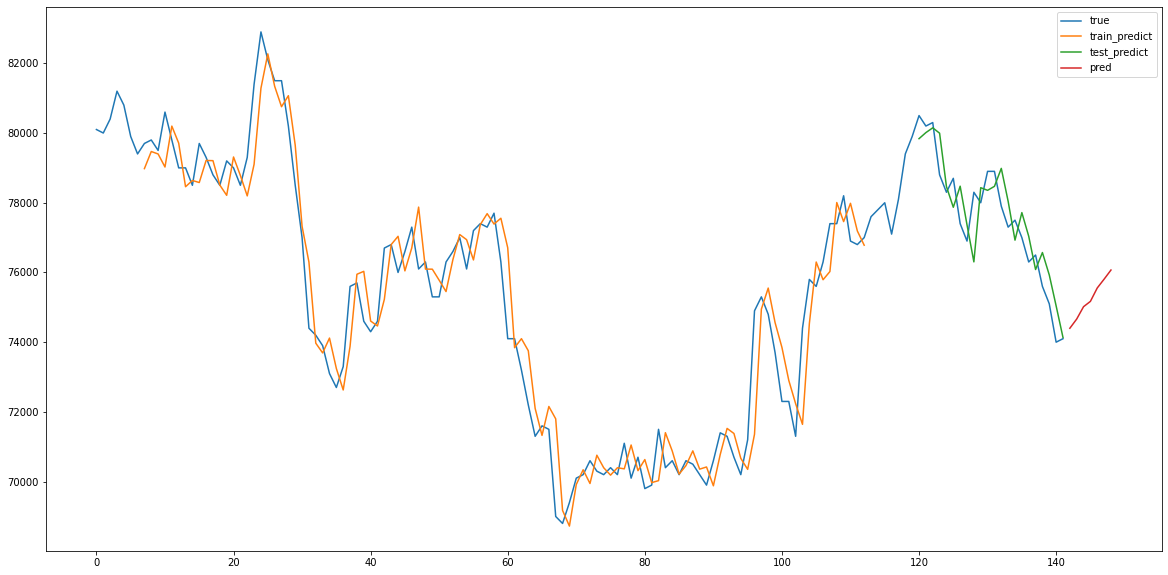

In [144]:
trainPredictPlot = np.zeros(len(dataset) + 7) # 
trainPredictPlot = trainPredictPlot.reshape(trainPredictPlot.shape[0], 1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(TrainPredict) + look_back] = TrainPredict
    
testPredictPlot = np.zeros(len(dataset) + 7)
testPredictPlot = testPredictPlot.reshape(testPredictPlot.shape[0], 1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(TrainPredict) + (look_back) * 2 : len(dataset) , :] = TestPredict

predPlot = np.zeros(len(dataset) + 7)
predPlot = predPlot.reshape(predPlot.shape[0], 1)
predPlot[:, :] = np.nan
predPlot[-7:] = x_pred[6].reshape(x_pred.shape[0], 1)
predPlot = scaler.inverse_transform(predPlot)# Min-Max변환된 값을 원래대로 되돌림
    
plt.figure(figsize = (20, 10))
plt.plot(dataset, label = "true")
plt.plot(trainPredictPlot, label = 'train_predict')
plt.plot(testPredictPlot, label = 'test_predict')
plt.plot(predPlot, label = 'pred')
plt.legend()


plt.show()

In [145]:
x_pred

array([[[0.47872305, 0.49148893, 0.43404245, 0.40212727, 0.3319149 ,
         0.33829784, 0.35740611]],

       [[0.49148893, 0.43404245, 0.40212727, 0.3319149 , 0.33829784,
         0.35740611, 0.37427947]],

       [[0.43404245, 0.40212727, 0.3319149 , 0.33829784, 0.35740611,
         0.37427947, 0.39690223]],

       [[0.40212727, 0.3319149 , 0.33829784, 0.35740611, 0.37427947,
         0.39690223, 0.40661767]],

       [[0.3319149 , 0.33829784, 0.35740611, 0.37427947, 0.39690223,
         0.40661767, 0.4311991 ]],

       [[0.33829784, 0.35740611, 0.37427947, 0.39690223, 0.40661767,
         0.4311991 , 0.44732121]],

       [[0.35740611, 0.37427947, 0.39690223, 0.40661767, 0.4311991 ,
         0.44732121, 0.46402597]]])